In [ ]:
# Implementation using GluonTS

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utility import helpers

from gluonts.dataset.common import ListDataset

from gluonts.torch.model.patch_tst import PatchTSTEstimator
from gluonts.dataset.util import to_pandas


In [2]:
def prepare_data_for_training(data: pd.DataFrame, prediction_length: int, start_date: pd.Timestamp):
    """
    Prepares the data for training; assumes that the input data is sorted by timestamp.
    Performs instance normalization as recommended in the paper. It normalizes each time series instance
    with zero mean and unit standard deviation. Later, mean and deviation are added back to the
    output prediction

    Args:
        data (pd.DataFrame): A DataFrame containing time series data, sorted by timestamp.
        prediction_length (int): The number of time steps to be predicted in the future, used to trim the training data.
    
    Returns:
        Tuple[ListDataset, ListDataset]: A tuple containing two ListDataset objects:
            - The first is the training dataset, where the last prediction_length time steps are removed.
            - The second is the test dataset, which uses the entire dataset.
        train_means(List): The mean of each time series instance of the training data
        train_stds(List): The standard deviation of each time series instance of the training data
    """

    # drop timestamp and instance_id
    # transpose to have timestamps as columns
    data_np = data.drop({'timestamp', 'instance_id'}, axis=1).to_numpy().T

    # # normalize
    # train_means = []
    # train_stds = []
    # for i,timeseries in enumerate(data_np):
    #     m, s = timeseries.mean(), timeseries.std()
    #     train_means.append(m)
    #     train_stds.append(s)
    #     data_np[i] = (timeseries - m) / s   

    # Convert timestamp index to PeriodIndex (assuming hourly frequency)
    start = pd.Period(start_date, freq="1h")

    # train dataset: 
    # Cut the last window of length "prediction_length".
    # Add "target" and "start" fields.
    # Convert to GluonTs ListDataset: A ListDataset is a dataset backed directly by list of dictionaries which must
    # have keys 'start' and 'target'. Each Dictionary corresponds to a univariate time series.

    train_ds = ListDataset(
        [{"target": x, "start": start} for x in data_np[:,:-prediction_length]], 
        freq="1h")
    train_ds

    # test dataset: 
    # Use the whole dataset
    # Add "target" and "start" fields
    test_ds = ListDataset(
        [{"target": x, "start": start} for x in data_np],
        freq="1h")

    return train_ds, test_ds#, train_means, train_stds

In [3]:
def visualize_data_gluonts(train_series, test_series):
    '''Visualizes the time series and test cutoff

    Args:
        train_series (ListDataset)
        test_series (ListDataset)
    '''

    # Number of series in the dataset
    n_series = len(test_series)

    # Create subplots with one row and n_series columns
    fig, axes = plt.subplots(n_series, 1, figsize=(10, 4 * n_series))

    titels = ['query_count', 'runtime', 'bytes_scanned']
    # Loop through each item in the ListDataset and plot it in a separate subplot
    for i, item in enumerate(zip(train_series, test_series)):
        train_series_pd = to_pandas(item[0])
        test_series_pd = to_pandas(item[1])
        test_series_pd.plot(ax=axes[i], title=titels[i], label='entire series')
        axes[i].axvline(train_series_pd.index[-1], color="r", linestyle='--', label='end of train series')
        # Add legend to each subplot
        axes[i].legend()
        axes[i].grid(which="both")
    plt.tight_layout()
    plt.show()

In [4]:
# load data
datamanager = helpers.DataManager('provisioned', 96)
data = datamanager.load_data()

c:\Users\reese\OneDrive\Desktop\UTN\ML_DE_project\.mlproject2\Lib\site-packages\pandas\core\indexes\base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


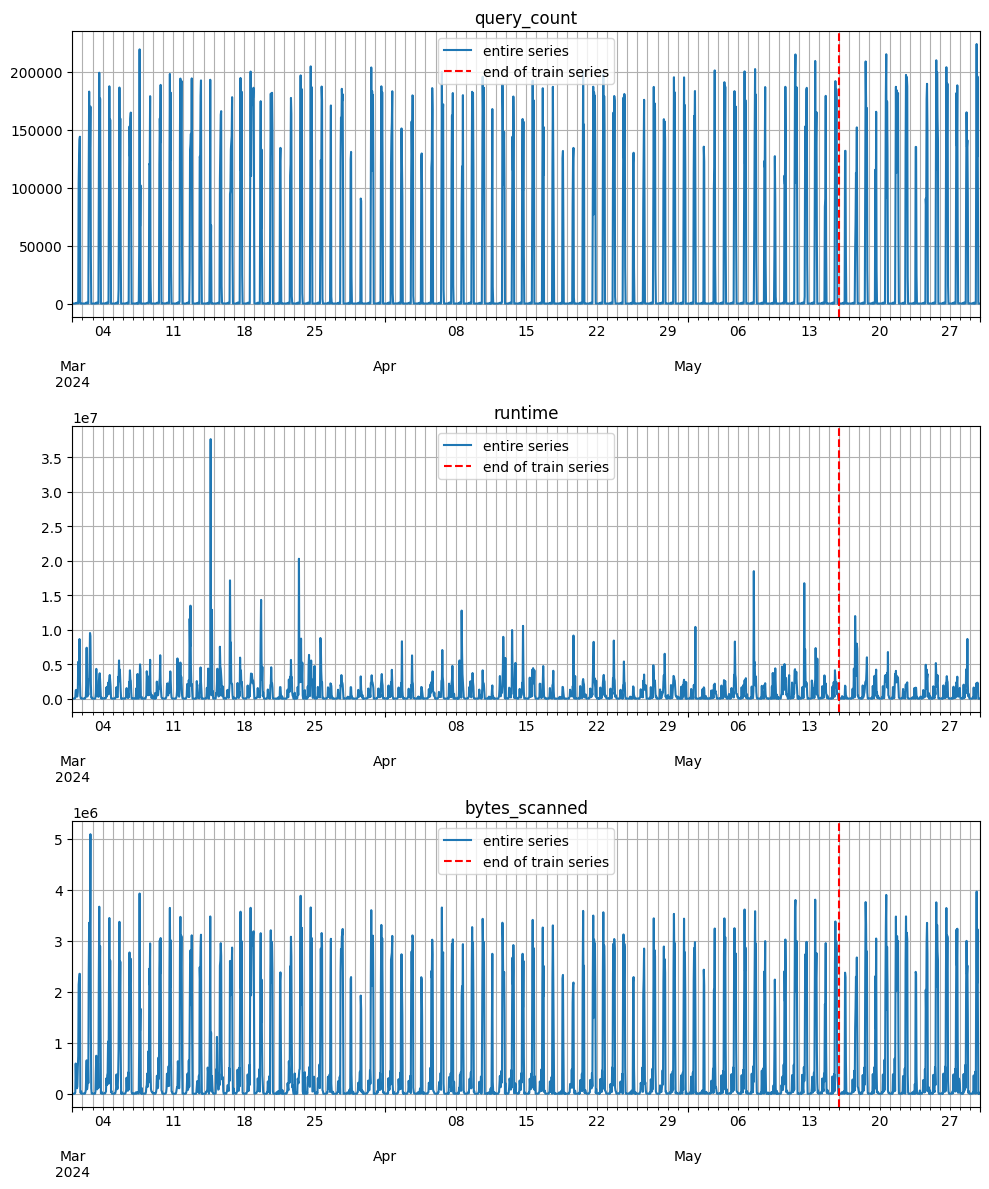

In [5]:
# prepare training data in gluonts format
start_date = pd.to_datetime('2024-03-01')
prediction_length = 24*2*7

train_ds, test_ds = prepare_data_for_training(data, prediction_length, start_date)
visualize_data_gluonts(train_ds, test_ds)


In [6]:
print(
    f"Length of forecasting window in test dataset: {len(to_pandas(next(iter(test_ds)))) - len(to_pandas(next(iter(train_ds))))}"
)
print(24*2*7)

Length of forecasting window in test dataset: 336
336


In [7]:
# instance normalization
# train
# predict

# hyperparamters to be tuned: 
# learning rate, num_encoder_layers, d_model, batch _size, max_epochs, and scaling

# prediction length two weeks
prediction_length = 24 * 7 * 2
# Number of time steps prior to prediction time that the model takes as inputs = lookback window
context_length = 10 * prediction_length
# patch 24 hours, with 12 hours stride
patch_len = 8
stride = 4
# Dimensionality of the transformer layers = embedding dimension
# kept small due to recommendation in paper
d_model = 16 # 128
# Number of attention heads in the Transformer encoder,  must divide d_model
nhead = 4
# Dimension of the feed-forward layer in the Transformer encoder
dim_feedforward = 64 #256
# Dropout probability in the Transformer encoder
dropout = 0.2
# Activation function in the Transformer encoder
activation = 'gelu'
# Number of encoder layers
num_encoder_layers = 2
# learning rate
lr = 1e-3
# Weight decay regularization parameter 
weight_decay = 1e-8
# batch size
batch_size = 4 # small batch size due to large context window
# Number of batches to be processed in each training epoch
#num_batches_per_epoch = 50

estimator = PatchTSTEstimator(
    prediction_length = prediction_length,
    context_length = context_length,
    patch_len = patch_len,
    stride = stride,
    d_model = d_model,
    nhead = nhead,
    dim_feedforward = dim_feedforward,
    dropout = dropout,
    activation = activation,
    num_encoder_layers = num_encoder_layers,
    lr = lr,
    weight_decay = weight_decay,
    batch_size = batch_size,
    #num_batches_per_epoch = num_batches_per_epoch,
    trainer_kwargs = {'max_epochs': 5} # limit training epochs
)

In [9]:
# # apply log scale to training and test series
# train_log_scale = np.log(train_ds[0]['target'] + 1)
# test_log_scale = np.log(test_ds[0]['target'] + 1)
# train_ds = [{'target': train_log_scale, 'start': train_ds[0]['start']}]
# test_ds = [{'target': test_log_scale, 'start': test_ds[0]['start']}]

In [8]:
# only train on query count
train_ds = [train_ds[0]]
test_ds = [test_ds[0]]

train_ds

[{'target': array([ 1.,  1.,  1., ..., 43., 11.,  1.], dtype=float32),
  'start': Period('2024-03-01 00:00', 'h')}]

In [9]:
#Train the estimator on the given data.
predictor = estimator.train(train_ds)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\reese\OneDrive\Desktop\UTN\ML_DE_project\.mlproject2\Lib\site-packages\lightning\pytorch\trainer\configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PatchTSTModel | 72.3 M | train
------------------------------------------------
72.3 M    Trainable params
13.4 K    Non-trainable params
72.3 M    Total params
289.116   Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 50: 'train_loss' reached 24.06608 (best 24.06608), saving model to 'c:\\Users\\reese\\OneDrive\\Desktop\\UTN\\ML_DE_project\\repo\\g8\\lightning_logs\\version_29\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 14.89989 (best 14.89989), saving model to 'c:\\Users\\reese\\OneDrive\\Desktop\\UTN\\ML_DE_project\\repo\\g8\\lightning_logs\\version_29\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 14.13903 (best 14.13903), saving model to 'c:\\Users\\reese\\OneDrive\\Desktop\\UTN\\ML_DE_project\\repo\\g8\\lightning_logs\\version_29\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 13.00790 (best 13.00790), saving model to 'c:\\Users\\reese\\OneDrive\\Desktop\\UTN\\ML_DE_project\\repo\\g8\\lightning_logs\\version_29\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 11.93736 (best 11.93736), saving mo

In [12]:
# save the trained model in tmp/
from pathlib import Path
predictor.serialize(Path("/tmp/"))

# # loads it back
# from gluonts.model.predictor import Predictor
# predictor_deserialized = Predictor.deserialize(Path("/tmp/"))

In [11]:
from gluonts.evaluation import make_evaluation_predictions

forecast_it, ts_it = make_evaluation_predictions(
    dataset=[test_ds[0]],  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths for evaluation
)

In [13]:
forecasts= list(forecast_it)
tss = list(ts_it)


In [52]:

estimated = forecasts[0].mean
true = tss[0][-336:].to_numpy().flatten()
# calculate q error

print(len(tss[0][-336:]))
print(len(estimated))

np.maximum(estimated, 1)
np.maximum(true, 1)
q_error = np.maximum(np.maximum(estimated,1) / np.maximum(true,1), np.maximum(true,1) / np.maximum(estimated,1))
print(np.median(np.sort(q_error)))


336
336
65.29503


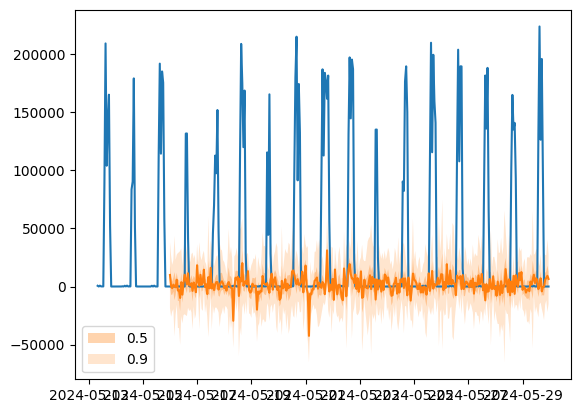

In [53]:
plt.plot(tss[0][-400:].to_timestamp())
forecasts[0].plot(show_label=True)
plt.legend()


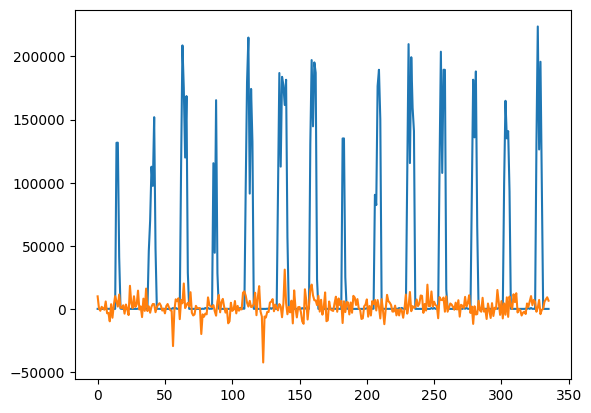

In [54]:
plt.plot(tss[0][-336:].values)
plt.plot(forecasts[0].mean)


In [ ]:
# Implementation using AutoGluon

c:\Users\reese\OneDrive\Desktop\UTN\ML_DE_project\.mlproject2\Lib\site-packages\pandas\core\indexes\base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)
Beginning AutoGluon training...
AutoGluon will save models to 'c:\Users\reese\OneDrive\Desktop\UTN\ML_DE_project\repo\g8\AutogluonModels\ag-20250222_130956'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.9
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          8
GPU Count:          0
Memory Avail:       6.42 GB / 15.85 GB (40.5%)
Disk Space Avail:   158.32 GB / 475.69 GB (33.3%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': SMAPE,
 'freq': 'h',
 'hyperparameters': {'PatchTST': {'batch_size': 

Initializing PatchTST Model...
Training PatchTST...


	-0.3148       = Validation score (-SMAPE)
	196.08  s     = Training runtime
	0.06    s     = Validation (prediction) runtime
Not fitting ensemble as only 1 model was trained.
Training complete. Models trained: ['PatchTST']
Total runtime: 196.24 s
Best model: PatchTST
Best model score: -0.3148
Model not specified in predict, will default to the model with the best validation score: PatchTST
Model not specified in predict, will default to the model with the best validation score: PatchTST


PatchTST Training Completed.
Evaluation Results: {'q_error': 3.197314074882329, 'mae': 1.0555244555354497, 'rme': 0.4993004093913289}


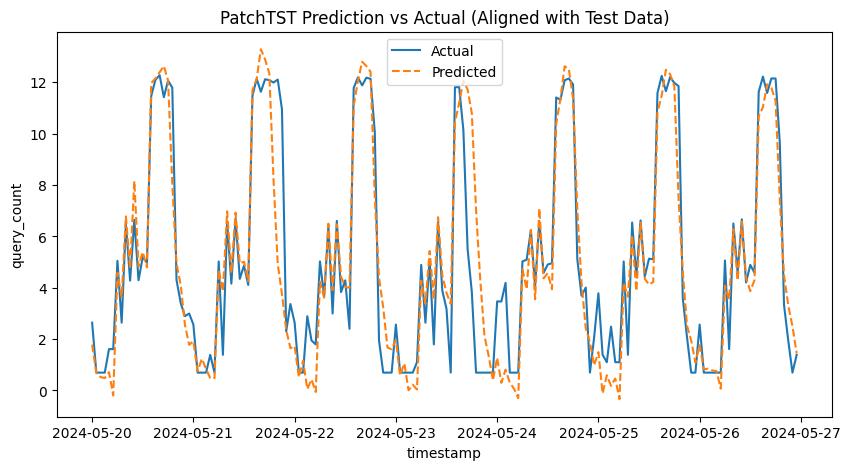

In [59]:
import pandas as pd
import numpy as np
import os
import logging
from typing import Dict, List
from autogluon.timeseries import TimeSeriesPredictor
from utility.helpers import DataManager
import matplotlib.pyplot as plt
import seaborn as sns

class PatchTST:
    """
    PatchTST implementation for time series forecasting using AutoGluon.
    """
    
    def __init__(self, prediction_length: int, freq: str = "h", hyperparameters: Dict = None):
        print("Initializing PatchTST Model...")
        self.prediction_length = prediction_length
        self.freq = freq
        self.model = None
        
        default_patchtst_hp = {
            "num_layers": 3,
            "hidden_size": 128,
            "dropout_rate": 0.2,
            "learning_rate": 5e-4,
            "context_length": prediction_length * 2,
            "batch_size": 16,
            "max_epochs": 50,
            "patience": 5,
        }
        self.hyperparameters = hyperparameters or {"PatchTST": default_patchtst_hp}
    
    def prepare_data(self, data: pd.DataFrame, target_column: str = "query_count") -> pd.DataFrame:
        """
        Prepares data for PatchTST model by formatting it in AutoGluon's long format.
        """
        data = data.copy()
        data["timestamp"] = pd.to_datetime(data["timestamp"])
        data = data.sort_values("timestamp")
        data["item_id"] = "item_1"
        return data[["item_id", "timestamp", target_column]]

    def train(self, train_data: pd.DataFrame, target_column: str = "query_count"):
        """
        Trains the PatchTST model.
        """
        prepared_data = self.prepare_data(train_data, target_column)
        
        print("Training PatchTST...")
        self.model = TimeSeriesPredictor(
            target=target_column,
            prediction_length=self.prediction_length,
            freq=self.freq,
            eval_metric='SMAPE'
        )
        
        self.model.fit(train_data=prepared_data, hyperparameters=self.hyperparameters)
        print("PatchTST Training Completed.")
    
    def predict(self, test_data: pd.DataFrame, target_column: str = "query_count") -> pd.DataFrame:
        """
        Generates predictions strictly within test timestamps.
        """
        if self.model is None:
            raise ValueError("Model must be trained before making predictions.")
        
        prepared_data = self.prepare_data(test_data, target_column)
        predictions = self.model.predict(prepared_data)
        
        forecast = predictions.loc["item_1"].reset_index().rename(columns={"index": "timestamp"})
        mean_forecast = forecast["0.5"] if "0.5" in forecast.columns else forecast.iloc[:, 1]
        
        predictions_df = pd.DataFrame({
            "timestamp": test_data["timestamp"].values,
            "mean": mean_forecast[:len(test_data)]
        })
        
        return predictions_df
    
    def evaluate(self, test_data: pd.DataFrame, target_column: str = "query_count") -> Dict[str, float]:
        """
        Evaluates PatchTST predictions against actual test data.
        """
        if self.model is None:
            raise ValueError("Model must be trained before evaluation.")
        
        predictions_df = self.predict(test_data, target_column)
        actual = test_data[target_column].values
        forecast = predictions_df["mean"].values[:len(actual)]
        
        mae = np.mean(np.abs(forecast - actual))
        q_errors = np.maximum(forecast / (actual + 1e-10), actual / (forecast + 1e-10))
        q_error = np.mean(q_errors)
        rme = np.mean(np.abs(forecast - actual) / (np.abs(actual) + 1e-10))
        
        return {"q_error": q_error, "mae": mae, "rme": rme}
    
    def save_model(self):
        if self.model is None:
            raise ValueError("No trained model to save.")
        self.model.save()
        print("Model saved successfully.")
    
    def load_model(self, path: str):
        if not os.path.exists(path):
            raise FileNotFoundError(f"No model file found at {path}")
        self.model = TimeSeriesPredictor.load(path)
        print(f"Model loaded from {path}.")

# Usage
if __name__ == "__main__":
    dataset_type = "provisioned"
    instance_number = 96
    
    datamanager = DataManager(dataset_type, instance_number)
    data = datamanager.load_data()
    data["timestamp"] = pd.to_datetime(data["timestamp"])
    data = data.sort_values("timestamp")
    data["query_count"] = np.log1p(data["query_count"])
    
    train1, test1, _, _ = datamanager.train_test_split(data)
    test1 = test1[test1["timestamp"] > train1["timestamp"].max()]
    
    prediction_duration = len(test1)
    model = PatchTST(prediction_length=prediction_duration, freq="h")
    model.train(train1, target_column="query_count")
    predictions = model.predict(test1, target_column="query_count")
    
    evaluation_results = model.evaluate(test1, target_column="query_count")
    print("Evaluation Results:", evaluation_results)
    
    plt.figure(figsize=(10, 5))
    sns.lineplot(x=test1["timestamp"], y=test1["query_count"], label="Actual")
    sns.lineplot(x=predictions["timestamp"], y=predictions["mean"], label="Predicted", linestyle="dashed")
    plt.title("PatchTST Prediction vs Actual (Aligned with Test Data)")
    plt.show()